## beautifulsoup & newspaper3k drawling

In [ ]:
from bs4 import BeautifulSoup
from newspaper import Article

#- 파싱할 뉴스 기사 주소입니다.
url = 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=030&aid=0002881076'

#- 언어가 한국어이므로 language='ko'로 설정해줍니다.
article = Article(url, language='ko')
article.download()
article.parse()

In [ ]:
#- 기사 제목을 출력합니다.
print('기사 제목 :')
print(article.title)
print('')

#- 기사 내용을 출력합니다.
print('기사 내용 :')
print(article.text)

In [ ]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)   
    news = requests.get(url)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [ ]:
#. 한 페이지당 뉴스 기사가 20개임을 감안하여 총 40개의 url리스트 받아오기
url_list = make_urllist(2, 101, 20200506)
print('뉴스 기사의 개수: ',len(url_list))

url_list1 = make_urllist(2, 101, 20200804)
print('뉴스 기사의 개수: ',len(url_list))

In [ ]:
#. 5개만 출력해 보기
url_list[:5]

In [ ]:
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [ ]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.text)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

경제 카테고리(코드 101)의 40개의 URL 리스트로부터 데이터프레임을 생성

In [ ]:
data = make_data(url_list, 101)
#- 상위 10개만 출력해봅니다.
data[:10]

## 3-8. 네이버 뉴스 기사 크롤링 (3) 데이터 수집 및 전처리
여러 카테고리에 뉴스들도 수집해보기 -> 특저 날짜의 사회, 생활/문화, IT/과학

In [ ]:
# 수집을 원하는 카테고리 코드를을 저장한 리스트를 만들어두기
code_list = [102, 103, 105]

code_list

In [ ]:
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [ ]:
df = make_total_data(1, code_list, 20200506)

In [ ]:
print('뉴스 기사의 개수: ',len(df))

In [ ]:
# n v a <- exclude all. or extract n
# 60개중 임의의 10개 샘플 선택하여 출력
df.sample(10)

## 대량크롤링


In [ ]:
# 아래 주석처리된 코드의 주석을 해제하고 실행을 하면 대량 크롤링이 진행됩니다. 
# 위에서 수행했던 크롤링의 100배 분량이 수행될 것입니다. 한꺼번에 너무 많은 크롤링 요청이 서버에 전달되지 않도록 주의해 주세요. 
# 기사 일자를 바꿔보면서 데이터를 모으면 더욱 다양한 데이터를 얻을 수 있게 됩니다. 

#df = make_total_data(100, code_list, 20200506)

## 아래 블럭만 실행하지 말기!!! 누적되서 망함

In [ ]:
# 크롤링한 뉴스 기사의 양이 많으므로 실수로 유실하지 않도록 csv 파일로 별도 저장

import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
###### csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
###### df.to_csv(csv_path, index=False)

###### if os.path.exists(csv_path):
######  print('{} File Saved!'.format(csv_path))

### 3-9. naver news article crawling (4) data preprocessing\
데이터를 가공/정제하여 모델의 훈련에 사용하기 좋은 숫자의 형태로 바꿔준다

In [ ]:
#. 저장해둔 csv파일을 다시 읽어서 dataframe으로 저장하기 위한 코드
import os
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

In [ ]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

In [ ]:
# data에 null값이 있진 않은지 확인
print(df.isnull().sum())

In [ ]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

데이터 탐색
---
각 카테고리별 샘플 분포 확인 -> matplotlib에 한글폰트 적용안될 수 있음 주의
[matplotlib 한글폰트 설정방법](https://followers.tistory.com/26)

In [ ]:
#. 한글 출력
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location='/home/aiffel/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524-ligature.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
plt.rc('font',family=font_name)
plt.text(0.3, 0.3, '한글', size=100)

In [ ]:
font_location='/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [ ]:
df['code'].value_counts().plot(kind = 'bar')

In [ ]:
# 실 개수 확인
print(df.groupby('code').size().reset_index(name = 'count'))

### 토큰화
자연어 처리 - 문자열은 특정 단위로 나누어지는데 이 특정 단위가 바로 토큰이다
토크나이징 - 문자열을 토큰으로 break down into pieces
[영어와 한국어의 토큰화의 차이](https://wikidocs.net/21698)   
-> 한국어 자연어처리의 경우에는 토큰화 과정을 주로 형태소 분석기를 사용해서 수행    
한국어의 경우 교착어라는 특성으로 인해 조사, 어미 등이 붙어있어 띄어쓰기 단위로
토큰화를 할 경우에는 같은 단어임에도 다른 단어로 인식될 수 있다.

In [ ]:
# 형태소 패키지 라이브러리 Mecab
# Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나눠줌
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

자연어 처리: 토큰화 결과가 얼마나 정확한지에 다라 그 성능에 많은 영향을 받는다    
형태소 분석기의 결과가 머신러닝 결과의 성능에 큰 영향을 주기도 한다

### 불용어 제거(stopwords)
토큰화 전처리 필수과정 - 불필요한 토큰들을 제거하는 불용어 제거     


In [ ]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

불용어 - 미리 짐작하여 한 번에 정의한는 것이 아니라 토큰화 과정을 거친 결과를 지속적으로 확인하면서 계속 추가하게 되는게 일반적이다

In [ ]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [ ]:
# 전체 데이터에 대해서 토큰화 및 불용어 제거를 수행한 뒤 첫 번째 샘플을 출력
text_data = preprocessing(df['news'])
print(text_data[0])

### ML모델 적용을 위해 필요한 도구들 가져오기

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [ ]:
# idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [ ]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

print(df.groupby('code').size().reset_index(name = 'count'))

기계는 텍스트보다 숫자를 더 잘 처리한다    
ML모델인 나이브 베이즈 분류기를 사용하기 위해서는 각 뉴스의 텍스트 데이터를 벡터로 변환할 필요가 있다    
TF-IDF 방법 사용

### 각 뉴스 문서를 TF-IDF 벡터로 바꾼 뒤 나이브 베이즈 분류기를 학습

`fit_transform()` 함수는 fit, transform을 연이어 수행하는 함수로, `CountVectorizer.fit_transform()` 은 단어 데이터를 학습하고 문서 데이터를 document-form matrix로 변환하는 두 가지 작업을 해 준다
[사이킷런 참고자료](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform)

In [ ]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트 하기

# 텍스트 입력을 자동으로 TF-IDF 벡터로 바꾸는 전처리 함수 만들기
# 이걸로 바로 txt -> 나이브 베이즈 분류기 입력으로 사용함으로써 용이한 테스트 가능

In [ ]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [ ]:
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
# 수집을 원하는 카테고리 코드를을 저장한 리스트를 만들어두기
code_list = [102, 103, 105]

code_list


# make total data
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df


print('뉴스 기사의 개수: ',len(df))
df.sample(10)

# 3-11. 프로젝트 - 모델 성능 개선하기

Text(0.3, 0.3, '한글')

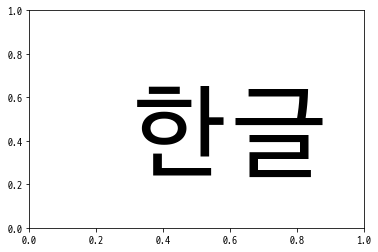

In [6]:
#. 한글 출력
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
font_location='/home/aiffel/.local/share/fonts/D2CodingBold-Ver1.3.2-20180524-ligature.ttf'
font_name=fm.FontProperties(fname=font_location).get_name()
plt.rc('font',family=font_name)
plt.text(0.3, 0.3, '한글', size=100)

news    0
code    0
dtype: int64
뉴스 기사의 개수:  2137 

    code  count
0  IT/과학    235
1     경제    902
2     사회    554
3  생활/문화    446


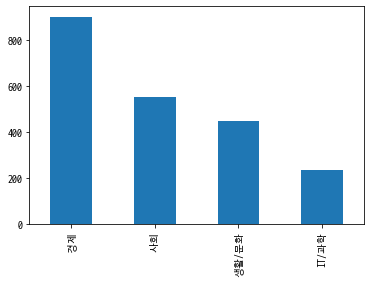

In [5]:
#. 저장해둔 csv파일을 다시 읽어서 dataframe으로 저장하기 위한 코드
import os
import pandas as pd
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data2.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

# data에 null값이 있진 않은지 확인
print(df.isnull().sum())

# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df),'\n')
df['code'].value_counts().plot(kind = 'bar')
print(df.groupby('code').size().reset_index(name = 'count'))

In [4]:
df.sample(10)

,news,code
694,사진게티이미지뱅크 사진게티이미지뱅크 전자신문 전자신문인터넷 무단전재 및 재배포 ...,경제
508,한국프랜차이즈산업협회가 가맹점 상생 지원을 실천하는 회원사 지원을 위해 개 회원사의...,경제
3059,자료환경부자료환경부지디넷코리아박영민 기자국내 물산업 사업체 수가 총 만천여개에 달하...,IT/과학
3009,디지털데일리 권하영기자 삼성전자가 기지국에서 속도를 구현하는 데 성공했다 이론상...,IT/과학
38,삼성전자 인도공장 연합뉴스 제공 삼성전자 인도공장 연합뉴스 제공현대차 인도공장 생산...,경제
1286,부산 해운대구 신곡초등은 최근 학년 신입생들에게 행복꾸러미 가방과 꽃다발을 전달했다...,사회
59,국내 최초 타임커머스 티몬사진이 최근 코로나 이슈로 사회적 거리두기가 계속되는 가운...,경제
796,중앙방역 대책본부는 오늘일 시 기준 코로나 확진자가 전날 시보다 명 증가했다고 밝혔...,경제
2409,동영상 뉴스선거일인 오늘도 일교차가 도에서 도까지 크게 벌어지겠습니다지금 홍천이나 ...,생활/문화
399,자료통계청아기 울음소리는 줄고 곡 소리는 점점 늘고 있다 기대수명 증가로 세 이상 ...,경제


In [5]:
# 불용어
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스']

## Step 1. 형태소 분석기 변경해 보기

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [9]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [10]:
# 형태소 패키지 라이브러리 Mecab
# Mecab의 .morphs를 사용하면 입력 문자열을 형태소 단위로 나눠줌
from konlpy.tag import Mecab
tokenizer = Mecab()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [13]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [14]:
# 전체 데이터에 대해서 토큰화 및 불용어 제거를 수행한 뒤 첫 번째 샘플을 출력
text_data = preprocessing(df['news'])
print(text_data[0])

기사 섹션 분류 안내 기사 섹션 정보 해당 언론사 분류 를 따르 고 습니다 언론사 개별 기사 를 개 이상 섹션 으로 중복 분류 습니다 닫 기


In [15]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

print(df.groupby('code').size().reset_index(name = 'count'))

훈련용 뉴스 기사의 개수 : 1602
테스트용 뉴스 기사의 개수 :  535
훈련용 레이블의 개수 :  1602
테스트용 레이블의 개수 :  535
    code  count
0  IT/과학    235
1     경제    902
2     사회    554
3  생활/문화    446


In [16]:
# 시간측정
import time

In [17]:
start=time.time()

text_data=preprocessing(df['news'])
print(text_data[0])

print("[Mecab 분석기 preprocessing 걸린 시간]", time.time()-start, 'sec')

기사 섹션 분류 안내 기사 섹션 정보 해당 언론사 분류 를 따르 고 습니다 언론사 개별 기사 를 개 이상 섹션 으로 중복 분류 습니다 닫 기
[Mecab 분석기 preprocessing 걸린 시간] 2.6997036933898926 sec


In [18]:
print(text_data[999])

대구 뉴시스 이지연 윤재옥 대구 달서구 미래 통합 당 후보 당선 확실 시 되 면서 환호 고 사진 윤 후보 측 제공 대구 뉴시스 이지연 윤재옥 대구 달서구 미래 통합 당 후보 당선 확실 시 되 면서 환호 고 사진 윤 후보 측 제공 대구 뉴시스 이지연 미래 통합 당 윤재옥 대구 달서구 국회의원 후보 선 가까워졌 일 치러진 제대 국회의원 선거 에서 오후 시분 기준 개표 율 득표율 기록 해 당선 확실 시 되 고 더불 어 민주당 허소 후보 를 기록 만 표 차 로 윤 후보 뒤지 고 년 생 인 윤재옥 후보 경남 합천군 출신 으로 경찰 대학교 를 나와 경북 지방 경찰 청장 역임 당시 강력 경찰 청장 후보 였 지만 다른 인물 선임 되 면서 경찰대 동기 자리 를 넘기 며 물러났 년 제대 국회의원 선거 에서 달 서구 득표 율 로 경찰대 출신 최초 로 당선 되 며 정계 입문 년 제대 국회의원 선거 에서 재선 성공 며 자유 국당 원 내수 석부 대표 를 맡 기 도 선 성공 눈앞 둔 그 달서구 상화 로 입체 화 사업 지하 화 추진 월 배 권 신 도시 도로망 확충 사업 약속 그 무엇 보다 주민 약속 반드시 행해 결과 로 보답 겠 다며 코로나 로 붕괴 된 대구 민생 경제 를 재생 데 집중 것 라고 강조 이어 대구 정치 적 위상 떨어지 지 않 도록 정치 적 책임 초심 잃 지 않 고 더 낮 게 더 뜨겁 게 일 겠 다고 다짐 공감 언론 뉴시스


### mecab 평가하기

In [19]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [20]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']

['생활/문화']

['경제']

['경제']


In [21]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       1.00      0.02      0.03        58
          경제       0.66      0.98      0.79       235
          사회       0.92      0.94      0.93       139
       생활/문화       1.00      0.39      0.56       103

    accuracy                           0.75       535
   macro avg       0.89      0.58      0.58       535
weighted avg       0.83      0.75      0.70       535



### (1) Hannanum 분석기

In [ ]:
from konlpy.tag import Hannanum
tokenizer=Hannanum()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

print(tokenizer.morphs(kor_text))
# stopwords에 ㄴ, ㅇ 을 추가해야 할까??


In [ ]:
start=time.time()

text_data=preprocessing(df['news'])
print(text_data[0])

print("[Hannanum 분석기 preprocessing 걸린 시간]", time.time()-start, 'sec')

In [ ]:
print(text_data[1])
print(len(text_data))

### 추가할 stopword : ㄹ, ㄴ, ㄴ다, 며, 고, 게, 와, 었, 었다, 으로, 한국경제, 재배포, 무단전재, 

### hannanum ML모델 적용하여 평가하기

In [ ]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

In [ ]:
print(text_data[1])
print(len(text_data))

### (2) Kkma 분석기 

In [ ]:
from konlpy.tag import Kkma
tokenizer=Kkma()

kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

# stopwords 었, ㄴ, 는, 다, 었다, 을 추가!?

In [ ]:
start=time.time()

text_data=preprocessing(df['news'])
print(text_data[0])

print("[Kkma 분석기 preprocessing 걸린 시간]", time.time()-start, 'sec')

### Kkma 형태소 분석기 ML 모델 적용하여 평가하기

In [ ]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

### (3) Komoran 형태소 분석기

In [ ]:
from konlpy.tag import Komoran
tokenizer=Komoran()
# stopwords
print(stopwords)
# 형태소 분석
print(tokenizer.morphs(kor_text))

In [ ]:
start=time.time()

text_data=preprocessing(df['news'])
print(text_data[0])

print("[Komoran 분석기 preprocessing 걸린 시간]", time.time()-start, 'sec')

### Komoran 형태소 분석기 ML 모델 적용하여 평가하기

In [ ]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
# evaluation
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

### (4) Okt 형태소 분석기

In [ ]:
from konlpy.tag import Okt
tokenizer=Okt()
# stopwords
print(stopwords)
# 형태소 분석
print(tokenizer.morphs(kor_text))

In [ ]:
start=time.time()

text_data=preprocessing(df['news'])
print(text_data[0])

print("[Okt 분석기 preprocessing 걸린 시간]", time.time()-start, 'sec')

### Okt 형태소 분석기 ML 모델 적용하여 평가하기

In [ ]:
#- 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 10)

# 나이브 베이즈 분류기 학습
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
# 테스트
# 임의의 뉴스에 대한 카테고리 확인하기
# 훈련, 테스트 데이터 아닌 임의 뉴스임
# clf.predict() : 임의의 입력에 대해 나이브 베이즈 분류기가 예측한 값을 리턴함
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["인도 로맨틱 코미디 영화 <까립까립 싱글>(2017)을 봤을 때 나는 두 눈을 의심했다. \
                          저 사람이 남자 주인공이라고? 노안에 가까운 이목구비와 기름때로 뭉친 파마머리와, \
                          대충 툭툭 던지는 말투 등 전혀 로맨틱하지 않은 외모였다. 반감이 일면서 \
                          ‘난 외모지상주의자가 아니다’라고 자부했던 나에 대해 회의가 들었다.\
                           티브이를 꺼버릴까? 다른 걸 볼까? 그런데, 이상하다. 왜 이렇게 매력 있지? 개구리와\
                            같이 툭 불거진 눈망울 안에는 어떤 인도 배우에게서도 느끼지 못한 \
                            부드러움과 선량함, 무엇보다 슬픔이 있었다. 2시간 뒤 영화가 끝나고 나는 완전히 이 배우에게 빠졌다"])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent= preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))
print()
new_sent = preprocessing(["코로나19 이후 주목받기 시작한 비대면(언택트) 서비스에서 데이터와 AI는 핵심 역할을 한다. 데이터3법 개정으로 각 기업·기관이 가지고 있던 활용되지 못한 데이터가 유통됨에 따라 상당한 시너지 효과가 발생할 것으로 기대된다. 바야흐로 ‘데이터 경제 생태계’ 조성의 시작인 셈이다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

In [ ]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

## Step1 분석기별 장단점, 처리속도, 성능
- 대략적인 장단점
    - Kkma: 제일 느리다는 단점이 있다
- 처리속도: Mecab <<<<< Kkma
- 성능(f1 score): 
mecab: 2.77/0.75
hannanum: 68.09/0.72
Kkma: 500.63/0.75
komoran: 27.64/0.75
okt: 57.87/0.73

## Step2. 성능튜닝